In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))


In [2]:
import pandas as pd
from agents.physical_agent import PhysicalAgent

df = pd.read_csv("../data/raw/diabetes.csv")

physical_agent = PhysicalAgent()
physical_output = physical_agent.preprocess(df)

physical_output.head()


,BloodPressure,BMI,SkinThickness,BloodPressure_missing,BMI_missing,SkinThickness_missing
0,72.0,33.6,35.0,0,0,0
1,66.0,26.6,29.0,0,0,0
2,64.0,23.3,29.0,0,0,1
3,66.0,28.1,23.0,0,0,0
4,40.0,43.1,35.0,0,0,0


In [3]:
physical_output.shape
physical_output.isna().sum()


BloodPressure            0
BMI                      0
SkinThickness            0
BloodPressure_missing    0
BMI_missing              0
SkinThickness_missing    0
dtype: int64

In [4]:
metadata = physical_agent.get_metadata()

metadata


PhysicalAgentMetadata(features_processed=['BloodPressure', 'BMI', 'SkinThickness'], original_zero_counts={'BloodPressure': 35, 'BMI': 11, 'SkinThickness': 227}, imputation_medians={'BloodPressure': 72.0, 'BMI': 32.3, 'SkinThickness': 29.0}, imputed_counts={'BloodPressure': 35, 'BMI': 11, 'SkinThickness': 227})

TO TEST LAB AGENT

In [5]:
from agents.lab_agent import LabAgent

lab_agent = LabAgent()
lab_output = lab_agent.preprocess(df)

lab_metadata = lab_agent.get_metadata()

lab_output.head(), lab_metadata


(   Glucose  Insulin  Insulin_missing
 0    148.0    125.0                1
 1     85.0    125.0                1
 2    183.0    125.0                1
 3     89.0     94.0                0
 4    137.0    168.0                0,
 LabAgentMetadata(features_processed=['Glucose', 'Insulin'], original_zero_counts={'Glucose': 5, 'Insulin': 374}, imputation_medians={'Glucose': 117.0, 'Insulin': 125.0}, imputed_counts={'Glucose': 5, 'Insulin': 374}))

Lab Agent test

In [6]:
from agents.demographic_agent import DemographicAgent

demo_agent = DemographicAgent()
demo_output = demo_agent.preprocess(df)
demo_metadata = demo_agent.get_metadata()

demo_output.head(), demo_metadata


(   Age  Pregnancies
 0   50            6
 1   31            1
 2   32            8
 3   21            1
 4   33            0,
 DemographicAgentMetadata(features_processed=['Age', 'Pregnancies'], original_zero_counts={'Age': 0, 'Pregnancies': 111}, imputation_medians={'Age': 29.0, 'Pregnancies': None}, imputed_counts={'Age': 0, 'Pregnancies': 0}))

Testing coordinationg agent

In [7]:
from agents.lab_agent import LabAgent
from agents.physical_agent import PhysicalAgent
from agents.demographic_agent import DemographicAgent
from coordinator.coordinator_agent import CoordinatorAgent

lab_agent = LabAgent()
physical_agent = PhysicalAgent()
demographic_agent = DemographicAgent()

coordinator = CoordinatorAgent(
    lab_agent=lab_agent,
    physical_agent=physical_agent,
    demographic_agent=demographic_agent
)

final_features = coordinator.run(df)
coord_metadata = coordinator.get_metadata()

final_features.head(), coord_metadata


(   Glucose  Insulin  Insulin_missing  BloodPressure   BMI  SkinThickness  \
 0    148.0    125.0                1           72.0  33.6           35.0   
 1     85.0    125.0                1           66.0  26.6           29.0   
 2    183.0    125.0                1           64.0  23.3           29.0   
 3     89.0     94.0                0           66.0  28.1           23.0   
 4    137.0    168.0                0           40.0  43.1           35.0   
 
    BloodPressure_missing  BMI_missing  SkinThickness_missing  Age  Pregnancies  
 0                      0            0                      0   50            6  
 1                      0            0                      0   31            1  
 2                      0            0                      1   32            8  
 3                      0            0                      0   21            1  
 4                      0            0                      0   33            0  ,
 CoordinatorMetadata(lab_metadata=LabAgentM

In [8]:
# STEP 6.1: Prepare features and target

X = final_features          # features from Coordinator
y = df["Outcome"]           # target column

X.shape, y.shape


((768, 11), (768,))

In [9]:
# STEP 6.2: Train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((614, 11), (154, 11), (614,), (154,))

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, solver="liblinear")
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[84 16]
 [27 27]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       100
           1       0.63      0.50      0.56        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154



In [12]:
import pandas as pd

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
6,BloodPressure_missing,0.631343
2,Insulin_missing,0.187947
10,Pregnancies,0.103975
4,BMI,0.069917
0,Glucose,0.032008
9,Age,0.007048
1,Insulin,-0.000035
5,SkinThickness,-0.001656
3,BloodPressure,-0.023632
8,SkinThickness_missing,-0.164307


In [13]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    base_score=0.5,
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,0.5
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [14]:
y_pred_xgb = xgb_model.predict(X_test)


In [15]:
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


[[82 18]
 [20 34]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



In [16]:
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


[[82 18]
 [20 34]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



In [17]:
import shap

def model_predict(X):
    return xgb_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(model_predict, X_train)
shap_values = explainer(X_test)


c:\Users\srira\anaconda3\envs\agentxhealth\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 155it [00:33,  4.64it/s]                         


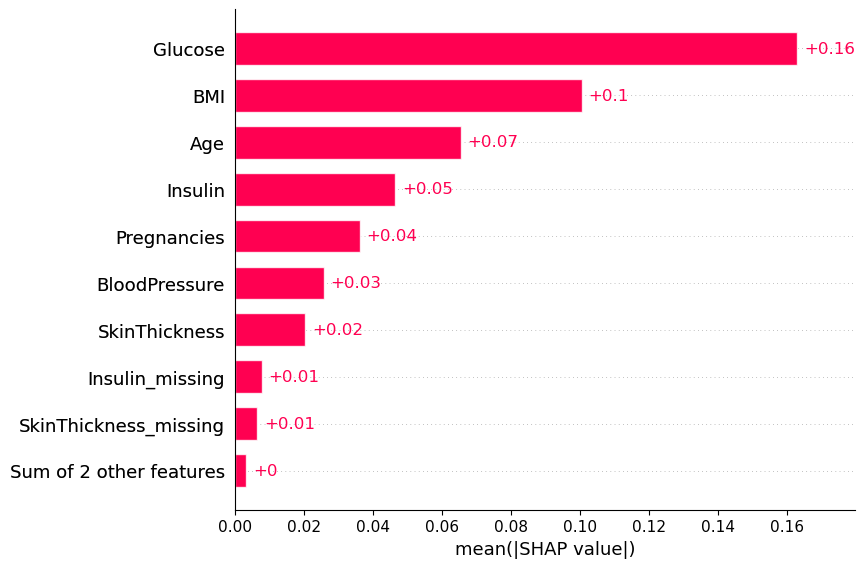

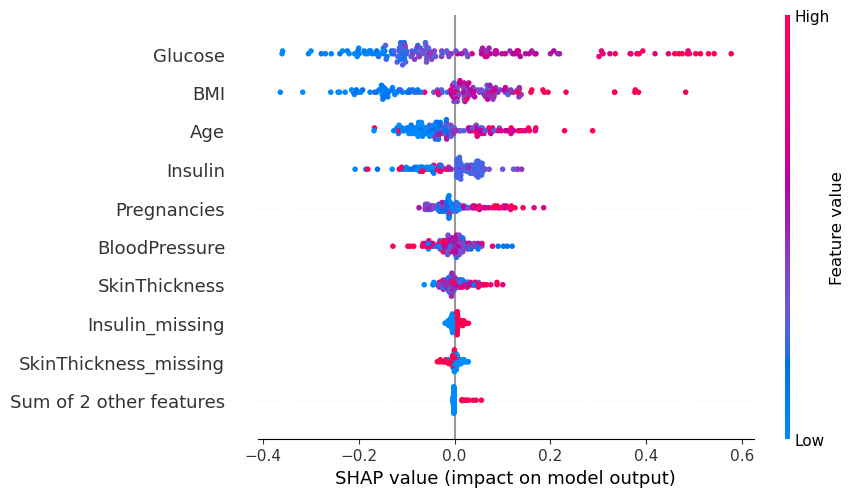

In [18]:
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)


## Final XGBoost + SHAP pipeline (locked)
